In [1]:
#Imports

import numpy as np
import os
import h5py
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from collections import OrderedDict
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
from tabulate import tabulate
from PIL import Image
import albumentations as A

d:\ANACONDA\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.4


 **Data Processsing**

In [4]:
# Directory containing .h5 files
directory = "E:\Research Project\ResearchProject\Data\BraTS2020_training_data\content\data"

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    file_path = os.path.join(directory, h5_files[25070])
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")
    
    
# Select GPU device for the training if available
if not torch.cuda.is_available():
    device=torch.device("cpu")
    print("Current device:", device)
else:
    device=torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))




Found 57195 .h5 files:
Example file names:['volume_100_slice_0.h5', 'volume_100_slice_1.h5', 'volume_100_slice_10.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 4.755863264388587
Array min val: -0.5070322108800785

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0
Current device: cuda - Type: NVIDIA GeForce RTX 3060 Ti


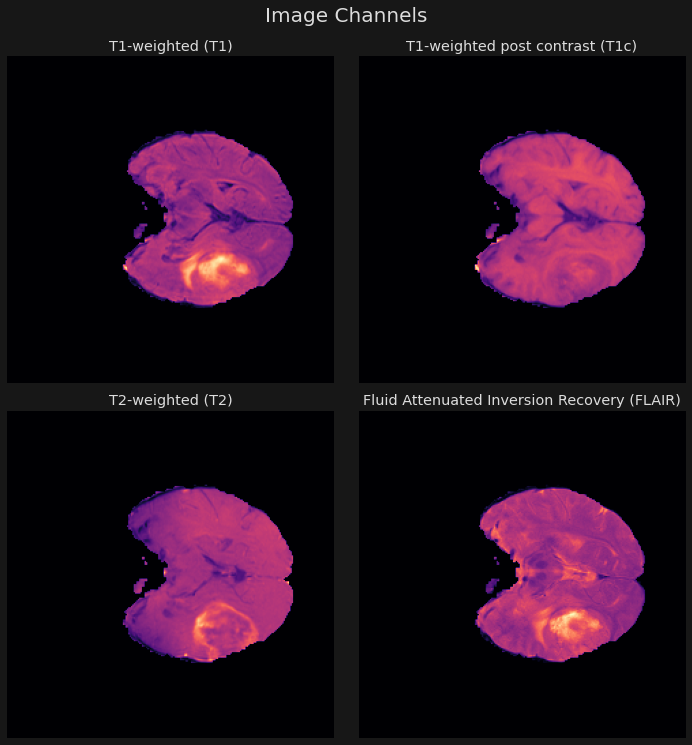

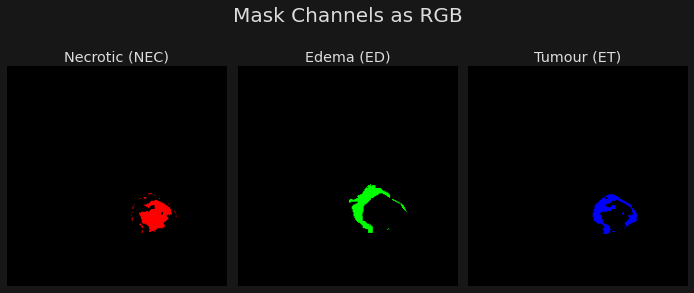

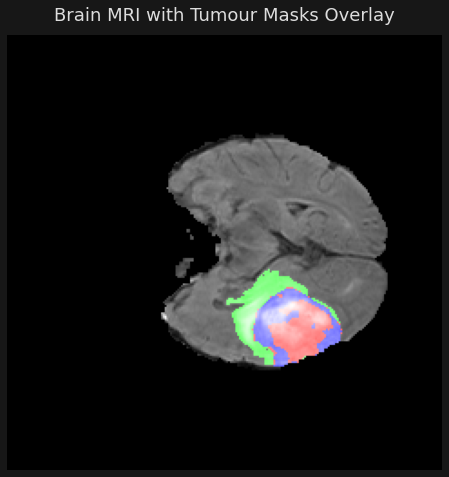

In [5]:
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()
    
    
# Sample image to view
sample_file_path = os.path.join(directory, h5_files[25070])
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

# View images using plotting functions
display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)


In [6]:
def pad_to_32(image, mask):
    c_img, h_img, w_img = image.shape
    c_mask, h_mask, w_mask = mask.shape

    # Calculate padding for height and width to make them divisible by 32
    pad_h = (32 - h_img % 32) % 32
    pad_w = (32 - w_img % 32) % 32

    # Pad image
    padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
    image = F.pad(image, padding)
    mask = F.pad(mask, padding)

    return image, mask

In [7]:
class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
    # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]

        # Reshape image: (H, W, C) -> (C, H, W)
        
        image = image.transpose((2, 0, 1))
        

        # Adjust pixel values for each channel in the image so they are between 0 and 1
        for i in range(image.shape[0]):    # Iterate over channels
            min_val = np.min(image[i])     # Find the min value in the channel
            image[i] = image[i] - min_val  # Shift values to ensure min is 0
            max_val = np.max(image[i]) + 1e-4     # Find max value to scale max to 1 now.
            image[i] = image[i] / max_val

        # Convert image to tensor
        image = torch.tensor(image, dtype=torch.float32)

        # Process mask
        # First, transpose mask to (C, H, W)
    
        mask = mask.transpose((2, 0, 1))
        
        # Convert mask to tensor
        mask = torch.tensor(mask, dtype=torch.long)
        
        # Create an empty channel with the same spatial dimensions
        empty_channel = torch.zeros((1, mask.size(1), mask.size(2)), dtype=mask.dtype)

        # Concatenate the empty channel to the mask
        mask = torch.cat((empty_channel, mask), dim=0)
        
        # Convert mask from one-hot encoding to class indices
        mask = mask.argmax(dim=0)  # Now mask shape is (H, W)
        
        # Add channel dimension to mask
        mask = mask.unsqueeze(0)  # Now mask shape is (1, H, W)
        
        # Apply any padding if necessary
        image, mask = pad_to_32(image, mask)

        return image, mask

# Build .h5 file paths from directory containing .h5 files
h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)

# Split the dataset into train and validation sets (90:10)
split_idx = int(0.9 * len(h5_files))
train_files = h5_files[:split_idx]
test_files = h5_files[split_idx:]

# Create the train and val datasets
train_dataset = BrainScanDataset(train_files)
test_dataset = BrainScanDataset(test_files, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(test_dataset, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break
for images, masks in test_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break


Training batch - Images shape: torch.Size([16, 4, 256, 256]) Masks shape: torch.Size([16, 1, 256, 256])
Validation batch - Images shape: torch.Size([16, 4, 256, 256]) Masks shape: torch.Size([16, 1, 256, 256])


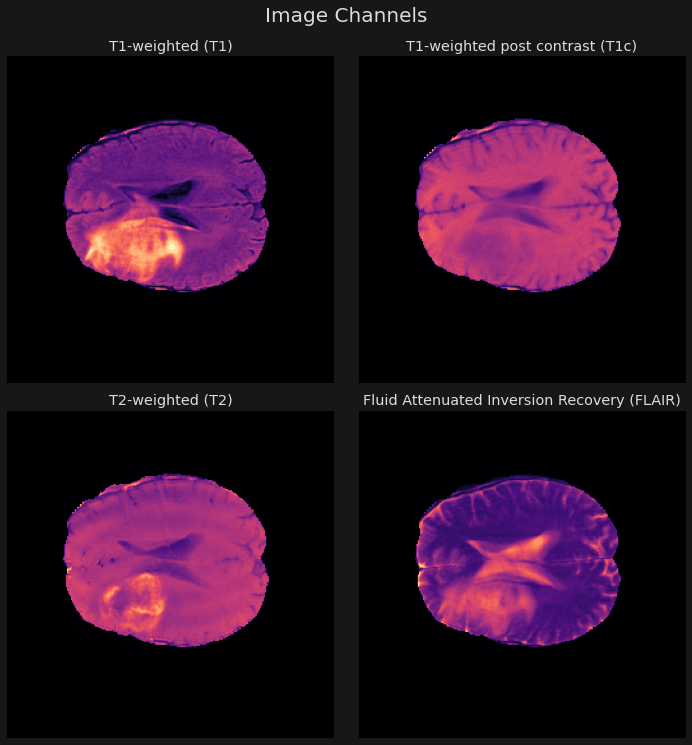

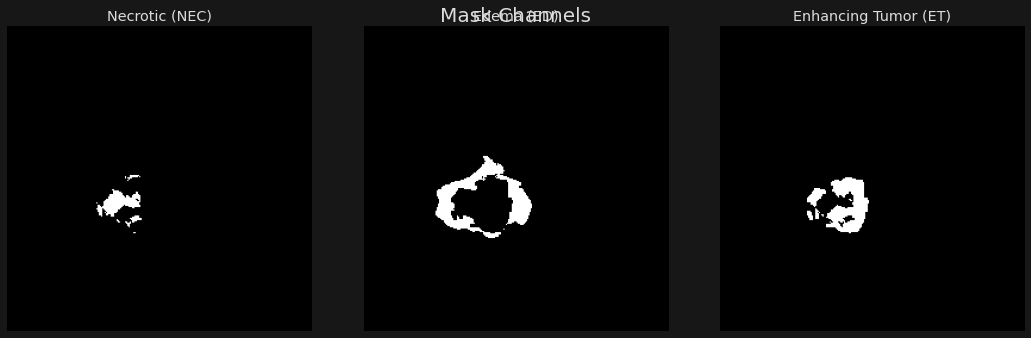

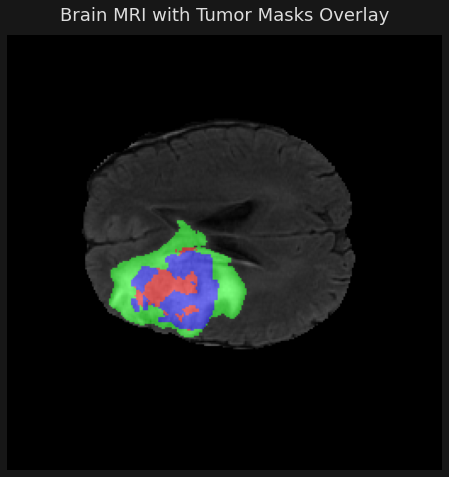

In [8]:
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color'] = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx], color='#DDDDDD')
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03, color='#DDDDDD')
    plt.show()

def display_mask_channels(mask, title='Mask Channels'):
    # Assuming mask is a 2D array of shape (H, W) with class indices
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Enhancing Tumor (ET)']
    class_indices = [1, 2, 3]  # Exclude background (0)

    fig, axes = plt.subplots(1, len(class_indices), figsize=(15, 5))
    for idx, class_idx in enumerate(class_indices):
        binary_mask = (mask == class_idx).astype(np.uint8)
        ax = axes[idx]
        ax.imshow(binary_mask, cmap='gray')
        ax.axis('off')
        ax.set_title(channel_names[idx], color='#DDDDDD')
    plt.suptitle(title, fontsize=20, y=0.93, color='#DDDDDD')
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumor Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel (T1-weighted)
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized]*3, axis=-1)

    # Define colors for each class
    colors = {
        1: [1, 0, 0],  # Red for Necrotic
        2: [0, 1, 0],  # Green for Edema
        3: [0, 0, 1],  # Blue for Enhancing Tumor
    }

    # Create a color mask
    color_mask = np.zeros_like(rgb_image)
    for class_idx, color in colors.items():
        binary_mask = (mask == class_idx)
        for c in range(3):
            color_mask[..., c] += binary_mask * color[c]

    # Overlay the color mask onto the image with transparency
    alpha = 0.5  # Transparency factor
    overlay_image = (1 - alpha) * rgb_image + alpha * color_mask

    plt.figure(figsize=(8, 8))
    plt.imshow(overlay_image)
    plt.title(title, fontsize=18, y=1.02, color='#DDDDDD')
    plt.axis('off')
    plt.show()

# Retrieve a sample from the test dataset
sample_image, sample_mask = test_dataset[0]  # Get the first sample

# Convert tensors to numpy arrays for visualization
sample_image = sample_image.numpy()
sample_mask = sample_mask.squeeze(0).numpy()  # Remove the channel dimension from mask

# Display the images and masks
display_image_channels(sample_image)
display_mask_channels(sample_mask)
overlay_masks_on_image(sample_image, sample_mask)
# Set print options to display the full array
np.set_printoptions(threshold=np.inf, linewidth=np.inf)



In [9]:
class BrainModel(pl.LightningModule):
    def __init__(self, model, optimizer, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        
    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, stage):
        image, mask = batch
        out = self.forward(image)
        loss = self.criterion(out, mask.long())
        tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(out, 1).unsqueeze(1), mask.long(), mode='multiclass', num_classes = 4)
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
        self.log(f"{stage}_IoU", iou, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_loss", loss) 
        return {"loss": loss, "iou": iou}
        
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")     

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")
    
    def configure_optimizers(self):
        return self.optimizer

In [10]:
arch = 'unet'
enc_name = 'resnet50'
classes = 4

model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 4,
                         classes = classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
criterion = smp.losses.DiceLoss(mode='multiclass', from_logits=True).to(device)
cbs = pl.callbacks.ModelCheckpoint(dirpath = f'./checkpoints_{arch}',
                                   filename = arch, 
                                   verbose = True, 
                                   monitor = 'valid_loss', 
                                   mode = 'min')

In [11]:
pl_model = BrainModel(model, optimizer, criterion)
trainer = pl.Trainer(callbacks=cbs, accelerator='gpu', max_epochs=50)
trainer.fit(pl_model, train_dataloader, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\ANACONDA\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\ANACONDA\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
d:\ANACONDA\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 3218: 'valid_loss' reached 0.22020 (best 0.22020), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 6436: 'valid_loss' reached 0.19467 (best 0.19467), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 9654: 'valid_loss' reached 0.18789 (best 0.18789), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 12872: 'valid_loss' reached 0.17735 (best 0.17735), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 16090: 'valid_loss' reached 0.16399 (best 0.16399), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 19308: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 22526: 'valid_loss' reached 0.15160 (best 0.15160), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 25744: 'valid_loss' reached 0.14902 (best 0.14902), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 28962: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 32180: 'valid_loss' reached 0.14087 (best 0.14087), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 35398: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 38616: 'valid_loss' reached 0.13445 (best 0.13445), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 41834: 'valid_loss' reached 0.13297 (best 0.13297), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 45052: 'valid_loss' reached 0.13092 (best 0.13092), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 48270: 'valid_loss' reached 0.12183 (best 0.12183), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 51488: 'valid_loss' reached 0.12013 (best 0.12013), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 54706: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 57924: 'valid_loss' reached 0.11812 (best 0.11812), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 61142: 'valid_loss' reached 0.11585 (best 0.11585), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 64360: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 67578: 'valid_loss' reached 0.11469 (best 0.11469), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 70796: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 74014: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 77232: 'valid_loss' reached 0.11329 (best 0.11329), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 80450: 'valid_loss' reached 0.10936 (best 0.10936), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 83668: 'valid_loss' reached 0.10885 (best 0.10885), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 86886: 'valid_loss' reached 0.10612 (best 0.10612), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 90104: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 93322: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 96540: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 99758: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 102976: 'valid_loss' reached 0.10012 (best 0.10012), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 106194: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 109412: 'valid_loss' reached 0.09999 (best 0.09999), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 112630: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 115848: 'valid_loss' reached 0.09857 (best 0.09857), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 119066: 'valid_loss' reached 0.09782 (best 0.09782), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 122284: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 125502: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 128720: 'valid_loss' reached 0.09744 (best 0.09744), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 131938: 'valid_loss' reached 0.09570 (best 0.09570), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 135156: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 138374: 'valid_loss' reached 0.09441 (best 0.09441), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 141592: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 144810: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 148028: 'valid_loss' reached 0.09305 (best 0.09305), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 151246: 'valid_loss' reached 0.09205 (best 0.09205), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 154464: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 157682: 'valid_loss' reached 0.09101 (best 0.09101), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 160900: 'valid_loss' reached 0.09020 (best 0.09020), saving model to 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


In [12]:
model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 4,
                         classes = classes).to(device)

best_model_path = 'E:\\Research Project\\ResearchProject\\checkpoints_unet\\unet-v1.ckpt'


state_dict = torch.load(cbs.best_model_path)['state_dict']
pl_state_dict = OrderedDict([(key[6:], state_dict[key]) for key in state_dict.keys()])

model.load_state_dict(pl_state_dict)
model.eval()

<ipython-input-12-3ad3595f4b1d>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cbs.best_model_path)['state_dict']


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [13]:
## TESTING
with torch.no_grad(): 
    
    outputs = []
    test_loss = 0.0
    iou = 0

    for image, mask in tqdm(test_dataloader):       

        image = image.to(device); mask = mask.to(device)
        output = model(image).to(device)
        tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(output, 1).unsqueeze(1), mask.long(), mode='multiclass', num_classes = 4)
        outputs.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
        loss = criterion(output, mask.long()) 
        test_loss += loss.item() 
    
    tp = torch.cat([x["tp"] for x in outputs])
    fp = torch.cat([x["fp"] for x in outputs])
    fn = torch.cat([x["fn"] for x in outputs])
    tn = torch.cat([x["tn"] for x in outputs])
    
    print(f'Test Loss: {test_loss / len(test_dataloader)}')
    print('IoU:', smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item())

100%|██████████| 358/358 [01:57<00:00,  3.03it/s]


Test Loss: 0.09015853270139108
IoU: 0.9970343708992004


<ipython-input-15-8bb3882eb8df>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.argmax(model(torch.tensor(image).unsqueeze(0).to(device)), 1)


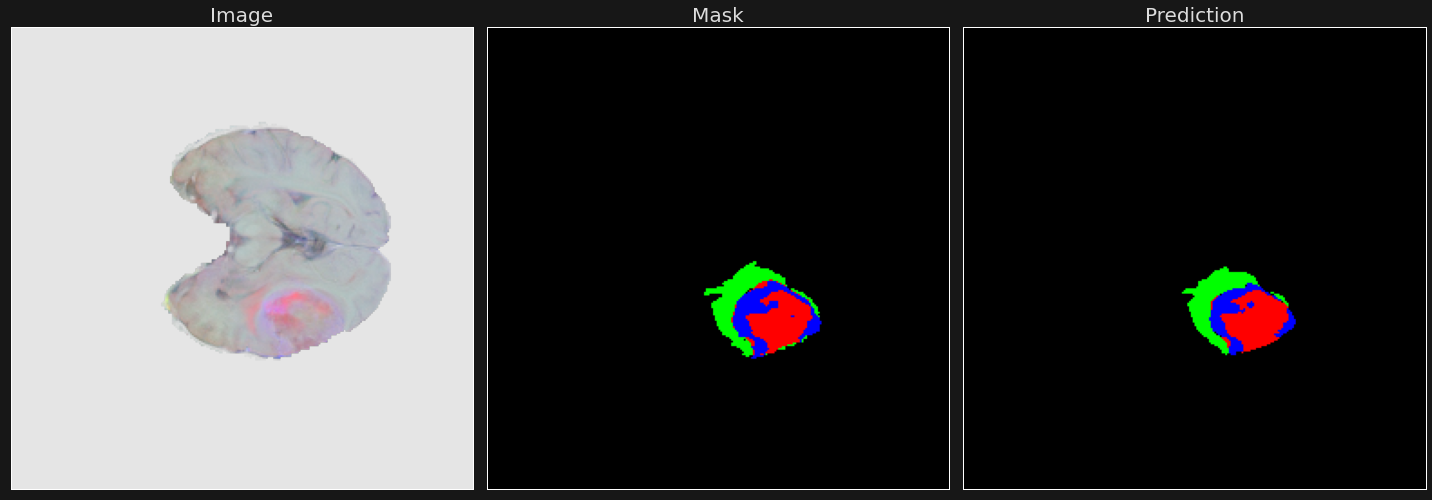

In [15]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

# Define a color palette (RGB values for each class)
palette = [
    [0, 0, 0],        # Background (class 0)
    [255, 0, 0],      # Class 1 - Red
    [0, 255, 0],      # Class 2 - Green
    [0, 0, 255],      # Class 3 - Blue
]

# Flatten the palette for use with PIL
pal = [value for color in palette for value in color]

# Set up random samples
random.seed(10)
samples = random.sample(range(len(test_dataset)), 5)

# Select the 3rd sample from the 5 random samples
sample_idx = samples[2]

# Columns for the figure
cols = ['Image', 'Mask', 'Prediction']
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharex='row', sharey='row', 
                         subplot_kw={'xticks': [], 'yticks': []}, tight_layout=True)

# Set column titles
for ax, col in zip(axes, cols): 
    ax.set_title(col, fontsize=20)

# Get the selected sample
image, mask = test_dataset[sample_idx]
pred = torch.argmax(model(torch.tensor(image).unsqueeze(0).to(device)), 1)

# Convert mask and prediction to NumPy for PIL Image
mask = Image.fromarray(mask.squeeze(0).cpu().numpy().astype('uint8')).convert('P')
pred = Image.fromarray(pred.squeeze(0).cpu().numpy().astype('uint8')).convert('P')

# Apply the color palette to the masks
mask.putpalette(pal)
pred.putpalette(pal)

# Display image, mask, and prediction
axes[0].imshow(np.array(image).transpose(1, 2, 0))
axes[1].imshow(mask)
axes[2].imshow(pred)

# Save the figure
fig.savefig(arch + '_single_sample.png')





In [16]:
metrics = np.round(torch.stack([torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.false_positive_rate(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.false_negative_rate(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.iou_score(tp, fp, fn, tn, reduction=None), 0)]).numpy(), 3)

info = {'Metrics': ['Recall', 'FPR', 'FNR', 'IoU'], 
        'Obstacles': metrics[:, 0], 
        'Water': metrics[:, 1],
        'Nature': metrics[:, 2],
        'Moving':metrics[:, 3],
        'Landing': metrics[:, 4]}

table = tabulate(info, headers='keys', tablefmt='fancy_grid')
print(table)

with open('table.txt', 'w') as f:
    f.write(table)

IndexError: index 4 is out of bounds for axis 1 with size 4